## Imports and constants

In [219]:
import os
import numpy as np
import scipy.stats as st
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

from onix.data_tools import get_experiment_data, open_analysis_folder, get_analysis_file_path
from onix.helpers import data_identifier, console_bold, present_float

%matplotlib inline

In [151]:
name = "Fluorescence Decay"
analysis_number = None
identifier = None

In [152]:
def add_label(ax, x=0.02, y=1.1):
    ax.text(x, y, identifier, transform=ax.transAxes)

In [205]:
class FluorescenceDecay:
    def __init__(self, data_signal, data_background=None):
        self._data_signal = data_signal
        self._data_background = data_background
        self._average_data()

    def _average_data(self):
        self._times = self._data_signal[0]["pmt_times"]
        if self._data_background is not None and (self._times != self._data_background[0]["pmt_times"]).all():
            raise Exception("Signal and background data must be taken using the same timing parameters.")
        self.times_ms = self._times * 1e3
        signal_voltages = self._data_signal[0]["pmt_voltages"]
        self.V_signal_avg = np.average(signal_voltages, axis=0)
        self.V_signal_err = np.std(signal_voltages, axis=0) / np.sqrt(len(signal_voltages))
        if self._data_background is not None:
            background_voltages = self._data_background[0]["pmt_voltages"]
            self.V_background_avg = np.average(background_voltages, axis=0)
            self.V_background_err = np.std(background_voltages, axis=0) / np.sqrt(len(background_voltages))
            self.V_diff_avg = self.V_signal_avg - self.V_background_avg
            self.V_diff_err = np.sqrt(self.V_signal_err ** 2 + self.V_background_err ** 2)
        else:
            self.V_background_avg = None
            self.V_background_err = None
            self.V_diff_avg = self.V_signal_avg
            self.V_diff_err = self.V_signal_err
    
    def get_test_data(self, test_time=10e-6, offset_time=100e-6, excitation_delay=10e-6):
        test_start_time = offset_time * 2
        test_end_time = offset_time * 2 + test_time + excitation_delay * 2
        test_mask = np.bitwise_and(
            self._times > test_start_time,
            self._times <= test_end_time,
        )
        self._test_end = test_end_time + offset_time
        self.test_times_ms = self.times_ms[test_mask]
        self.V_signal_test_avg = self.V_signal_avg[test_mask]
        self.V_signal_test_err = self.V_signal_err[test_mask]

    def get_decay_data(self, excitation_time=5e-3, excitation_delay=10e-6):
        decay_start_time = self._test_end + excitation_delay * 2 + excitation_time
        decay_mask = self._times > decay_start_time
        self.decay_times_ms = self.times_ms[decay_mask]
        self.V_diff_decay_avg = self.V_diff_avg[decay_mask]
        self.V_diff_decay_err = self.V_diff_err[decay_mask]

    def voltage_offset_removal(self, offset_measure_time=8e-3):
        offset_mask = self._times > offset_measure_time
        offset_avg = np.average(self.V_diff_avg[offset_mask])
        V_diff_offset_free_avg = self.V_diff_decay_avg - offset_avg
        V_diff_offset_free_err = self.V_diff_decay_err
        cutoff_index = np.argmax(V_diff_offset_free_avg <= 0)
        self.offset_free_times = self.decay_times_ms[:cutoff_index]
        self.V_diff_offset_free_avg = V_diff_offset_free_avg[:cutoff_index]
        self.V_diff_offset_free_err = V_diff_offset_free_err[:cutoff_index]

## Setup

In [206]:
data = FluorescenceDecay(get_experiment_data(82), get_experiment_data(83))
identifier = "data " + data_identifier(data_numbers) + ", analysis " + data_identifier([analysis_number])

In [157]:
if input(f"Create new analysis folder? (y/{console_bold('n')}) ") == "y":
    analysis_number = open_analysis_folder(name)
else:
    if input(f"Keep current analysis number of {analysis_number}? ({console_bold('y')}/n) ") == "n":
        analysis_number = int(input("Enter analysis number: "))
identifier = "data " + data_identifier(data_numbers) + ", analysis " + data_identifier([analysis_number])
print(f"Current analysis number is {analysis_number}")

Create new analysis folder? (y/n) y
Current analysis number is 65


## Overall plot

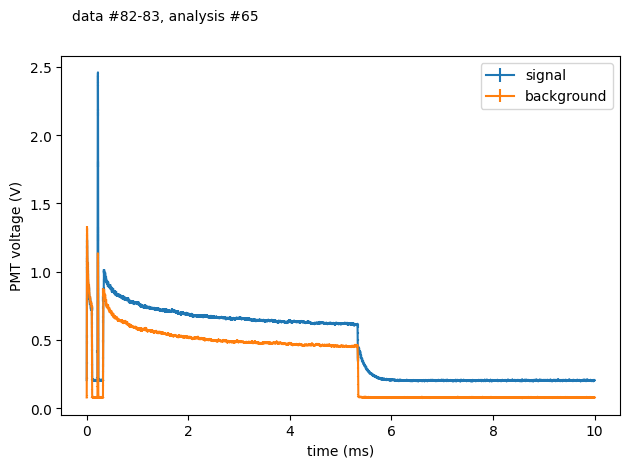

In [207]:
fig, ax = plt.subplots()
add_label(ax)
ax.errorbar(data.times_ms, data.V_signal_avg, data.V_signal_err, label="signal")
ax.errorbar(data.times_ms, data.V_background_avg, data.V_background_err, label="background")
ax.set_xlabel("time (ms)")
ax.set_ylabel("PMT voltage (V)")
ax.legend()
plt.tight_layout()
plt.savefig(get_analysis_file_path(analysis_number, str(analysis_number) + "_signal_and_background.pdf"))
plt.show()

## Test data

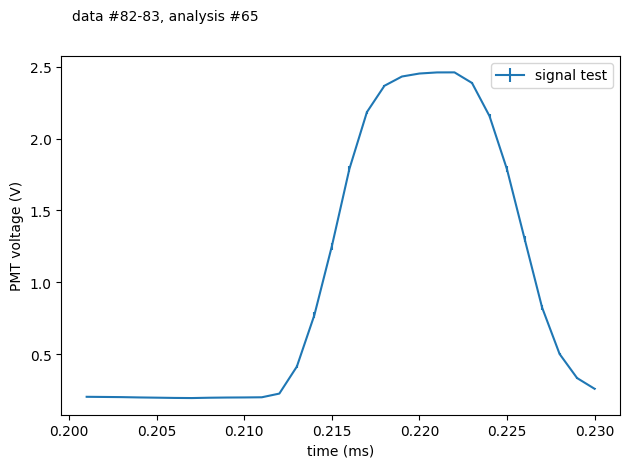

In [208]:
data.get_test_data()
fig, ax = plt.subplots()
add_label(ax)
ax.errorbar(data.test_times_ms, data.V_signal_test_avg, data.V_signal_test_err, label="signal test")
ax.set_xlabel("time (ms)")
ax.set_ylabel("PMT voltage (V)")
ax.legend()
plt.tight_layout()
plt.savefig(get_analysis_file_path(analysis_number, str(analysis_number) + "_test.pdf"))
plt.show()

## decay data

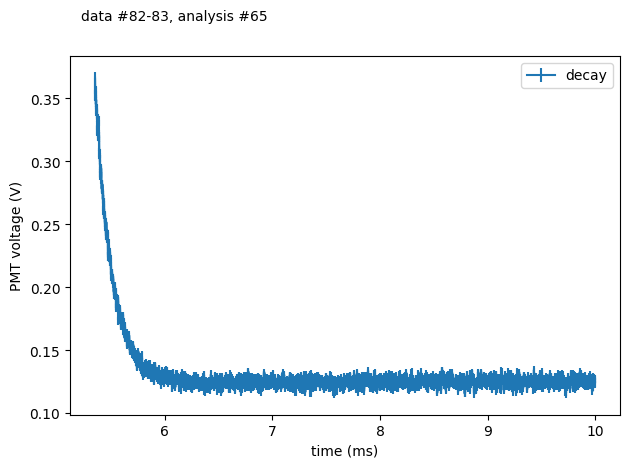

In [209]:
data.get_decay_data()
fig, ax = plt.subplots()
add_label(ax)
ax.errorbar(data.decay_times_ms, data.V_diff_decay_avg, data.V_diff_decay_err, label="decay")
ax.set_xlabel("time (ms)")
ax.set_ylabel("PMT voltage (V)")
ax.legend()
plt.tight_layout()
plt.savefig(get_analysis_file_path(analysis_number, str(analysis_number) + "_decay.pdf"))
plt.show()

## background free data

In [214]:
def exp_fit(times, voltages, voltages_err):
    def _fit_func(t, tau, a):
        return a * np.exp(-t / tau)
    return curve_fit(
        _fit_func, times, voltages,
        p0=[0.5, 10], sigma=voltages_err, absolute_sigma=True,
    )

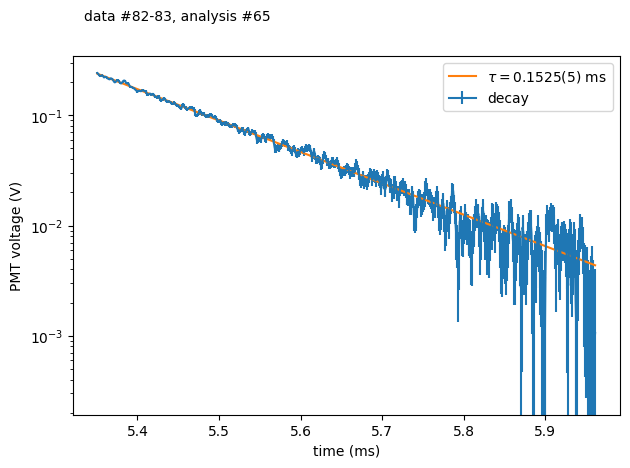

In [220]:
data.voltage_offset_removal()

popt, pcov = exp_fit(data.offset_free_times, data.V_diff_offset_free_avg, data.V_diff_offset_free_err)
perr = np.sqrt(np.diag(pcov))
text = present_float(popt[0], perr[0])

fig, ax = plt.subplots()
add_label(ax)
ax.errorbar(data.offset_free_times, data.V_diff_offset_free_avg, data.V_diff_offset_free_err, label="decay")
ax.plot(data.offset_free_times, np.exp(-data.offset_free_times / popt[0]) * popt[1],
        label=r"$\tau=" + text + "$ ms")
ax.set_xlabel("time (ms)")
ax.set_ylabel("PMT voltage (V)")
ax.set_yscale("log")
ax.legend()
plt.tight_layout()
plt.savefig(get_analysis_file_path(analysis_number, str(analysis_number) + "_decay_no_bg.pdf"))
plt.show()

array([4.95088615e-04, 4.82147957e+13])